# Session 3~4. CNN을 활용한 문제 해결

## 준비과정

### import libraries

In [1]:
# 기본
import sys # directory 접근 등 system 관련 기능 지원
import os # os관련 기능 지원
import gc # 메모리 할당 관련 기능 지원
import bcolz # binary data에 최적화된 압축 지원
from random import randint
import numpy as np # array 생성 및 계산 기능 지원
import pandas as pd # data 처리 및 시각화 관련 기능 지원  
import matplotlib.pyplot as plt # 시각화 관련 기능 지원
import matplotlib.image as mpimg # 이미지 특화 시각화 관련 기능 지원
import seaborn as sns # 시각화 및 통계 관련 기능 지원
from tqdm import tqdm
%matplotlib inline

### Amazon 위성사진 데이터 다운받기

In [2]:
# dataset 경로 설정
def get_jpeg_data_files_paths():
    data_root_folder = os.path.abspath("./input/") # ()안의 경로를 기준으로 절대 경로 생성
    train_jpeg_dir = os.path.join(data_root_folder, 'train-jpg') # train 이미지 데이터 경로 설정
    test_jpeg_dir = os.path.join(data_root_folder, 'test-jpg') # test 이미지 데이터 경로 설정
    test_jpeg_additional = os.path.join(data_root_folder, 'test-jpg-additional') # additional test 이미지 데이터 경로 설정
    train_csv_file = os.path.join(data_root_folder, 'train_v2.csv') # train csv 데이터 경로 설정
    return [train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file] # 생성한 경로 반환

In [3]:
# kaggle downloader
from kaggle_data.downloader import KaggleDataDownloader

competition_name = "planet-understanding-the-amazon-from-space"

train, train_u = "train-jpg.tar.7z", "train-jpg.tar"
test, test_u = "test-jpg.tar.7z", "test-jpg.tar"
test_additional, test_additional_u = "test-jpg-additional.tar.7z", "test-jpg-additional.tar"
test_labels = "train_v2.csv.zip"
save_dataset_path = "./input/"
is_datasets_present = False

# dataset의 저장 경로 존재 여부 확인
datasets_path = get_jpeg_data_files_paths()
for dir_path in datasets_path:
    if os.path.exists(dir_path):
        is_datasets_present = True

In [4]:
if not is_datasets_present:
    # "ID"와 "pw"에 kaggle ID와 password를 입력해 kaggle에서 dataset 다운로드 준비
    downloader = KaggleDataDownloader("angelno.3sachiel@gmail.com", "zhRlfl1*", competition_name)
    
    train_output_path = downloader.download_dataset(train, save_dataset_path) # train dataset을 저장할 경로 설정
    downloader.decompress(train_output_path, save_dataset_path) # train_output_path에 다운 받은 7z 파일을 tar file로 압축해제
    downloader.decompress(destination_path + train_u, save_dataset_path) # tar file을 압축 해제하여 train image dataset 획득
    os.remove(train_output_path) # 7z 파일 제거
    os.remove(save_dataset_path + train_u) # tar 파일 제거
    
    test_output_path = downloader.download_dataset(test, save_dataset_path) # test dataset을 저장할 경로 설정
    downloader.decompress(test_output_path, save_dataset_path) # # test_output_path에 다운 받은 7z 파일을 tar file로 압축해제
    downloader.decompress(destination_path + test_u, save_dataset_path) # tar file을 압축 해제하여 train image dataset 획득
    os.remove(test_output_path) # 7z 파일 제거
    os.remove(save_dataset_path + test_u) # tar 파일 제거
    
    test_add_output_path = downloader.download_dataset(test_additional, destination_path) # additional test dataset을 저장할 경로 설정
    downloader.decompress(test_add_output_path, save_dataset_path) # test_add_output_path에 다운 받은 7z 파일을 tar file로 압축해제
    downloader.decompress(destination_path + test_additional_u, save_dataset_path) # tar file을 압축 해제하여 train image dataset 획득
    os.remove(test_add_output_path) # 7z 파일 제거
    os.remove(save_dataset_path + test_additional_u) # tar 파일 제거
    
    test_labels_output_path = downloader.download_dataset(test_labels, save_dataset_path) # label dataset 저장한 다운로드 경로 생성
    downloader.decompress(test_labels_output_path, save_dataset_path) # test_labels_output_path에 저장된 zip 파일을 압축해제
    os.remove(test_labels_output_path) # zip 파일 제거
else:
    print("이미 데이터셋이 존재합니다.")

이미 데이터셋이 존재합니다.


## Part.01 이미지 전처리

## 사진 이미지를 어떻게 CNN의 입력값으로 변환할까?

### OpenCV를 이용한 이미지 추출 및 전처리

In [5]:
import cv2
train_path = save_dataset_path + "train-jpg/"
image_file_name = "train_1234.jpg"
image = cv2.imread(train_path + image_file_name)
print(image.shape)
print(image.dtype)

(256, 256, 3)
uint8


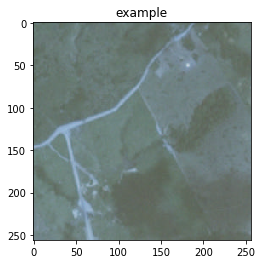

In [6]:
plt.imshow(image)
plt.title("example")
plt.show()

#### resize

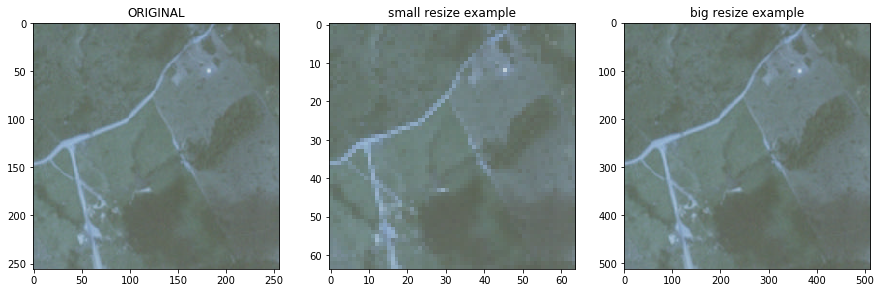

In [7]:
height, width = image.shape[:2]
image_resize_big = cv2.resize(image, (2 * width, 2 * height), interpolation = cv2.INTER_CUBIC)
image_resize_small = cv2.resize(image, (64, 64))

plt.figure(figsize = (15, 5))
plt.subplot(131), plt.imshow(image), plt.title("ORIGINAL")
plt.subplot(132), plt.imshow(image_resize_small), plt.title("small resize example")
plt.subplot(133), plt.imshow(image_resize_big), plt.title("big resize example")
plt.show()

#### Rotate

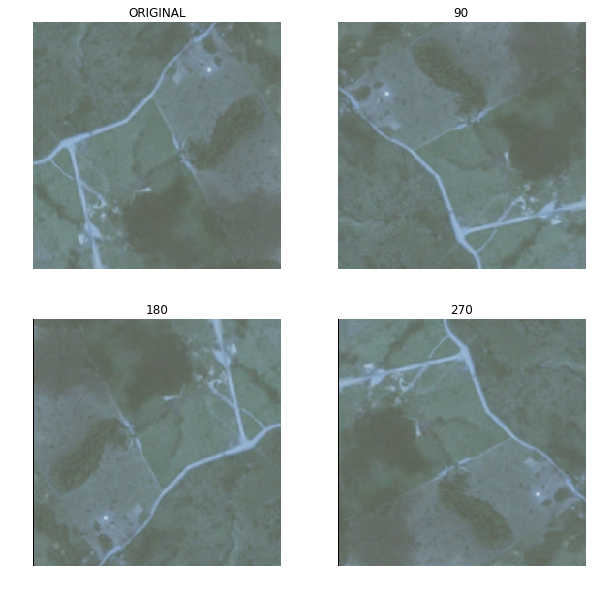

In [8]:
rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), 90, 1)
image_rotate_90 = cv2.warpAffine(image, rotation_matrix, (width, height))
image_rotate_180 = cv2.warpAffine(image_rotate_90, rotation_matrix, (width, height))
image_rotate_270 = cv2.warpAffine(image_rotate_180, rotation_matrix, (width, height))

plt.figure(figsize = (10, 10))
plt.subplot(221), plt.imshow(image), plt.axis("off"), plt.title('ORIGINAL')
plt.subplot(222), plt.imshow(image_rotate_90), plt.axis("off"), plt.title('90')
plt.subplot(223), plt.imshow(image_rotate_180), plt.axis("off"), plt.title('180')
plt.subplot(224), plt.imshow(image_rotate_270), plt.axis("off"), plt.title('270')
plt.show()

#### Filp

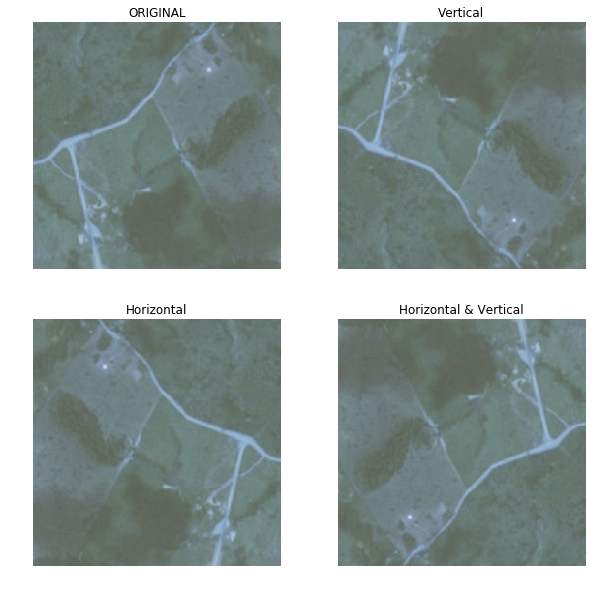

In [9]:
image_vertical_flip = cv2.flip(image, 0)
image_horizontal_flip = cv2.flip(image, 1)
image_horizontal_vertical_flip = cv2.flip(image_vertical_flip, 1)

plt.figure(figsize = (10, 10))
plt.subplot(221), plt.imshow(image), plt.axis("off"), plt.title('ORIGINAL')
plt.subplot(222), plt.imshow(image_vertical_flip), plt.axis("off"), plt.title('Vertical')
plt.subplot(223), plt.imshow(image_horizontal_flip), plt.axis("off"), plt.title('Horizontal')
plt.subplot(224), plt.imshow(image_horizontal_vertical_flip), plt.axis("off"), plt.title('Horizontal & Vertical')
plt.show()

#### shear

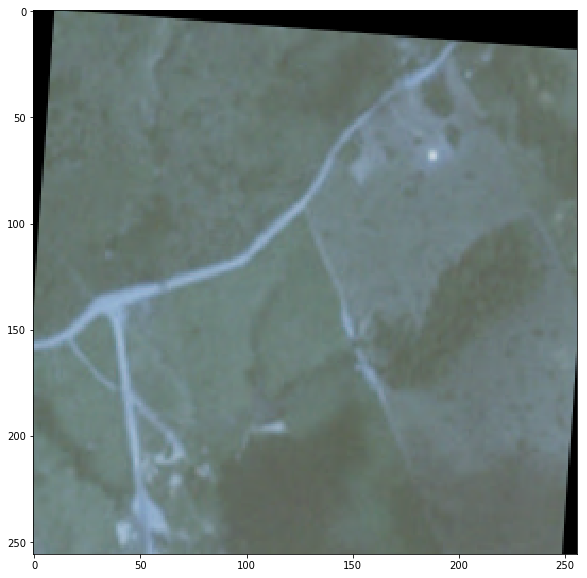

In [10]:
height, width = image.shape[:2]
shear_range = 20

point1 = int(width * 0.01)
point2 = int(height * 0.5) + point1
point_set1 = np.float32([[point1, point1],[point2, point1],[point1, point2]])

shear_point1 = point1 + shear_range - shear_range / 2
shear_point2 = point2 + shear_range - shear_range / 2

point_set2 = np.float32([[shear_point1, point1], [shear_point2, shear_point1], [point1, shear_point2]])
shear_M = cv2.getAffineTransform(point_set1, point_set2)

image_sheared = cv2.warpAffine(image, shear_M, (width, height))

plt.figure(figsize = (10, 10))
plt.imshow(image_sheared)
plt.show()

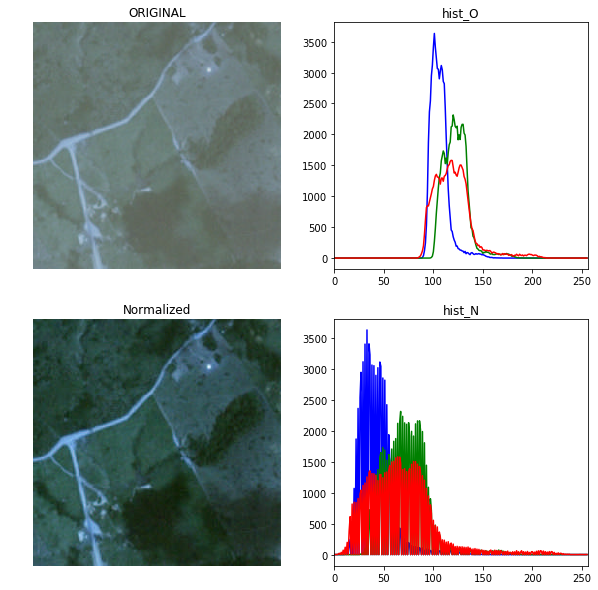

In [11]:
image_normalized = cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX)

colors = ('b','g','r')
plt.figure(figsize = (10, 10))
plt.subplot(221), plt.imshow(image), plt.axis("off"), plt.title('ORIGINAL')
plt.subplot(222), plt.title('hist_O')
for index, color in enumerate(colors):
    histogram = cv2.calcHist([image], [index], None, [256], [0, 256])
    plt.plot(histogram, color = color)
    plt.xlim([0,256])
plt.subplot(223), plt.imshow(image_normalized), plt.axis("off"), plt.title('Normalized')
plt.subplot(224), plt.title('hist_N')
for index, color in enumerate(colors):
    histogram = cv2.calcHist([image_normalized], [index], None, [256], [0, 256])
    plt.plot(histogram, color = color)
    plt.xlim([0,256])
plt.show()

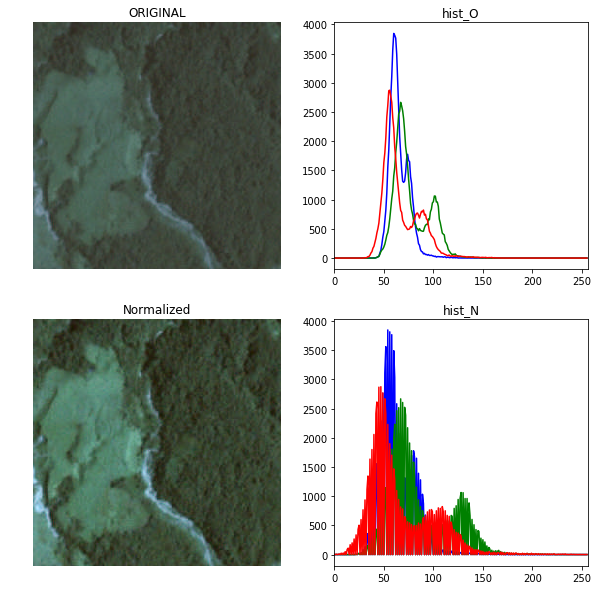

In [12]:
image2 = cv2.imread(train_path + "train_1.jpg")
image2_normalized = cv2.normalize(image2, None, 0, 255, norm_type=cv2.NORM_MINMAX)
plt.figure(figsize = (10, 10))
plt.subplot(221), plt.imshow(image2), plt.axis("off"), plt.title('ORIGINAL')
plt.subplot(222), plt.title('hist_O')
for index, color in enumerate(colors):
    histogram = cv2.calcHist([image2], [index], None, [256], [0, 256])
    plt.plot(histogram, color = color)
    plt.xlim([0,256])
plt.subplot(223), plt.imshow(image2_normalized), plt.axis("off"), plt.title('Normalized')
plt.subplot(224), plt.title('hist_N')
for index, color in enumerate(colors):
    histogram = cv2.calcHist([image2_normalized], [index], None, [256], [0, 256])
    plt.plot(histogram, color = color)
    plt.xlim([0,256])
plt.show()

### 자동차등록증에서 차대번호 인식하기

#### 자동차등록증 이미지 데이터 불러오기

(1675, 1200, 3)


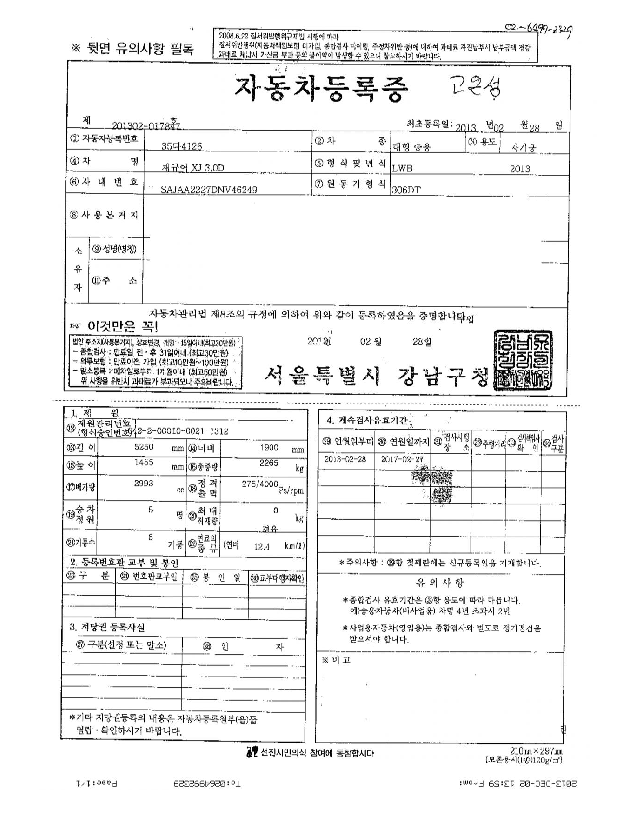

In [13]:
LOAD_PATH = "./Project/Image/"

#FILE_NAME, FILE_INDEX = "AQ12651390522069_1.jpg", 211
FILE_NAME, FILE_INDEX = "CQ1386032953_1.jpg", 378

raw = cv2.imread(LOAD_PATH+FILE_NAME)
print (raw.shape)
plt.figure(figsize = (10, 20))
plt.imshow(raw)
plt.axis("off")
plt.show()

#### 회색조 이미지로 바꾸기

(1675, 1200)


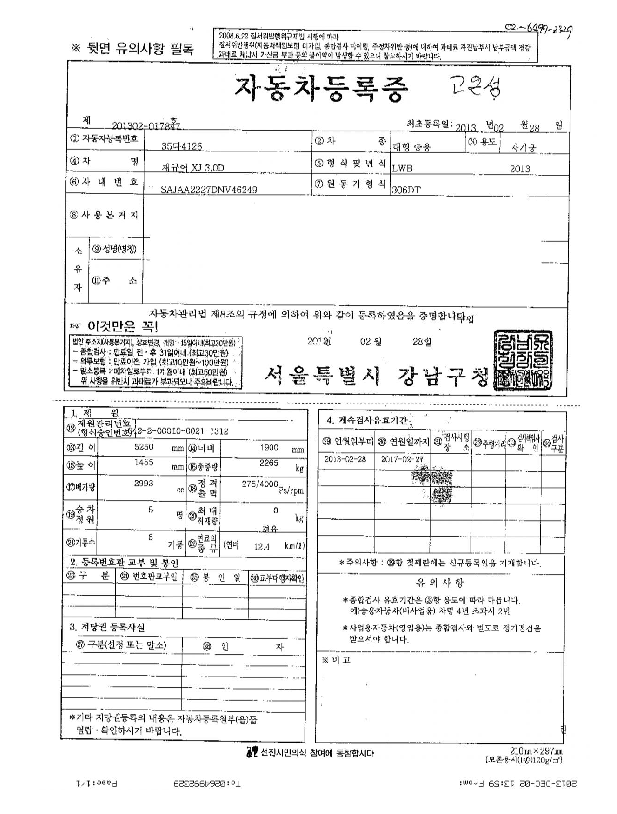

In [14]:
img  = raw.copy()

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img_gray.shape)
plt.figure(figsize = (10, 20))
plt.imshow(img_gray, cmap = "gray")
plt.axis("off")
plt.show()

#### threshold 조절하기

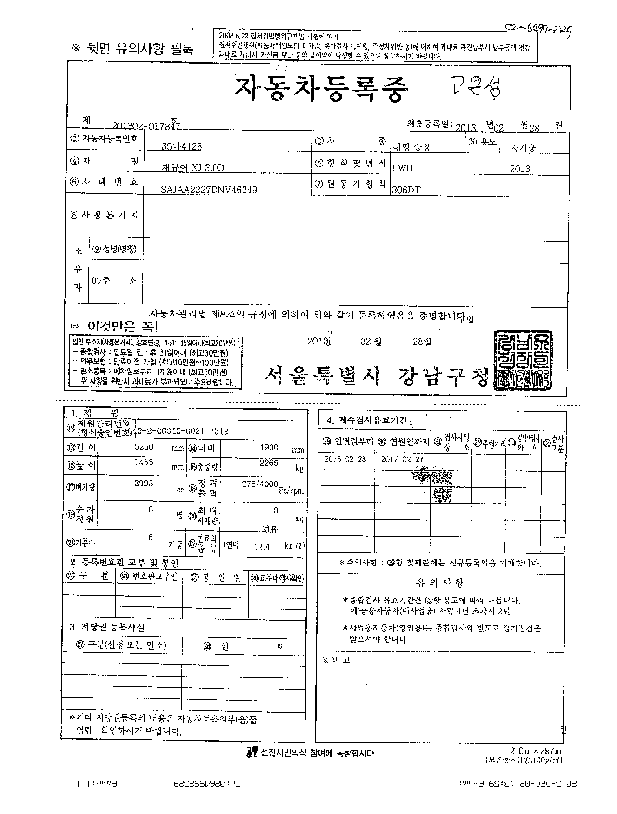

In [15]:
#img_normalized = cv2.equalizeHist(img_gray)
ret, img_normalized = cv2.threshold(img_gray, 127, 255, 0)
plt.figure(figsize = (10, 20))
plt.imshow(img_normalized, cmap = "gray")
plt.axis("off")
plt.show()

#### contour를 사용해 예상영역에 사각형 씌우기

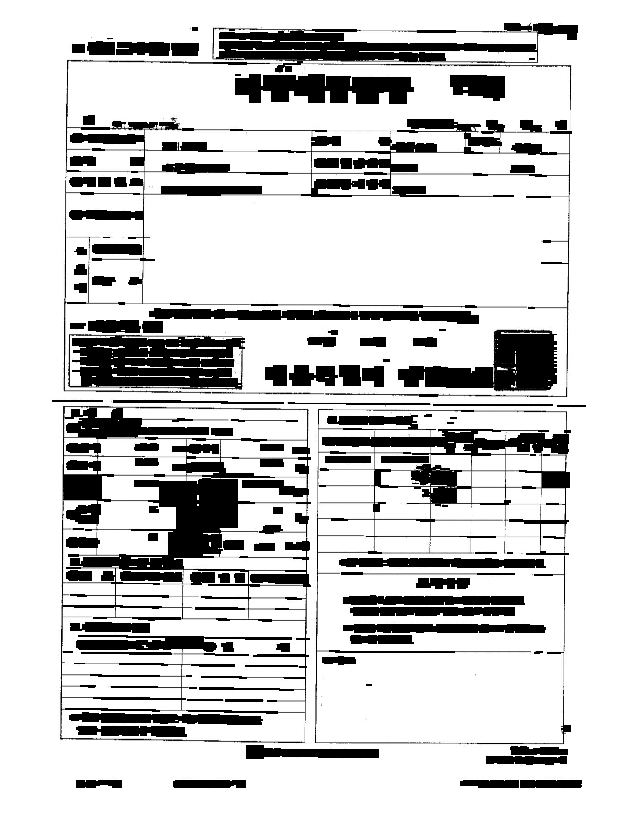

In [16]:
image, contours, hierachy = cv2.findContours(img_normalized, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

idx =0 
for cnt in contours:
    idx += 1
    x, y, w, h = cv2.boundingRect(cnt)

    channel = img.shape
    if (w < channel[0] * 0.05):   ## Image, 5%
        roi = img[y: y + h, x: x + w]
        imgwcon = cv2.rectangle(img, (x, y), (x + w + 10, y + h), (0, 0, 0), -1)

plt.figure(figsize = (10, 20))
plt.imshow(img)
plt.axis("off")
plt.show()

In [30]:
def nothing(x):
    pass

cv2.namedWindow('image')
cv2.createTrackbar('K','image',1,20, nothing)

while(1):
    if cv2.waitKey(1) & 0xFF == 27:
        break
    k = cv2.getTrackbarPos('K','image')

    #(0,0)이면 에러가 발생함으로 1로 치환
    if k == 0:
        k = 1

    # trackbar에 의해서 (1,1) ~ (20,20) kernel생성
    kernel = np.ones((k, k), np.float32)/(k * 2)
    dst = cv2.filter2D(img, -1, kernel)

    cv2.imshow('image', dst)

cv2.destroyAllWindows()

KeyboardInterrupt: 

#### 번짐을 사용한 얇은 선 제거 및 사각형 합치기

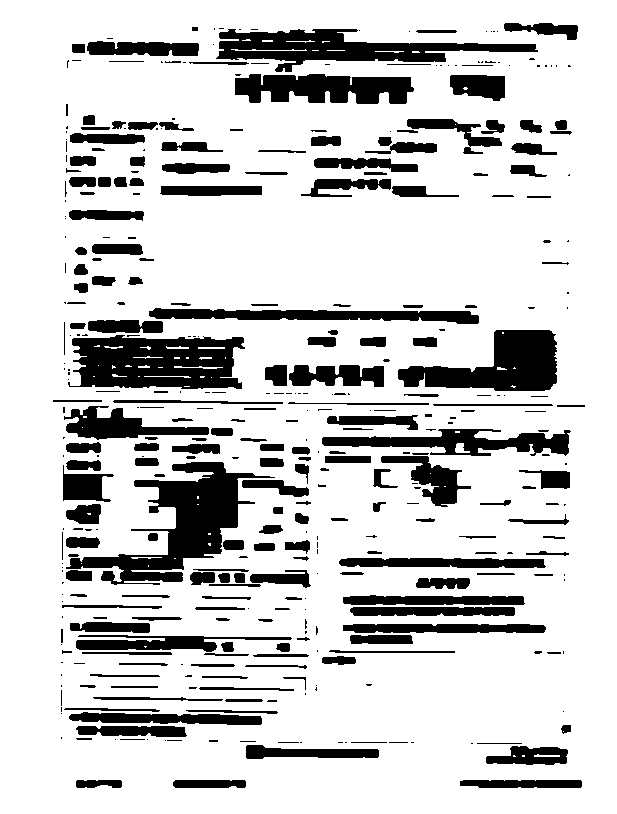

In [17]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.blur(gray, (5, 5))
ret, thresh = cv2.threshold(blur, 127, 255, 0)

plt.figure(figsize = (10, 20))
plt.imshow(thresh, cmap = "gray")
plt.axis("off")
plt.show()

#### 다시 contour 수행해서 차대번호 찾기

2 904 1653 265 18 (1675, 1200, 3) 0.1582089552238806 0.015 14.722222222222221
3 288 1653 158 18 (1675, 1200, 3) 0.09432835820895523 0.015 8.777777777777779
8 1065 1598 55 7 (1675, 1200, 3) 0.03283582089552239 0.005833333333333334 7.857142857142857
9 444 1578 289 31 (1675, 1200, 3) 0.17253731343283582 0.025833333333333333 9.32258064516129
20 513 1570 48 5 (1675, 1200, 3) 0.028656716417910448 0.004166666666666667 9.6
21 431 1569 37 4 (1675, 1200, 3) 0.02208955223880597 0.0033333333333333335 9.25
25 274 1566 35 4 (1675, 1200, 3) 0.020895522388059702 0.0033333333333333335 8.75
28 174 1564 54 5 (1675, 1200, 3) 0.032238805970149255 0.004166666666666667 10.8
29 79 1563 37 5 (1675, 1200, 3) 0.02208955223880597 0.004166666666666667 7.4
32 79 1536 240 25 (1675, 1200, 3) 0.14328358208955225 0.020833333333333332 9.6
36 64 1507 418 30 (1675, 1200, 3) 0.24955223880597016 0.025 13.933333333333334
44 400 1479 82 7 (1675, 1200, 3) 0.04895522388059702 0.005833333333333334 11.714285714285714
52 154 1450 

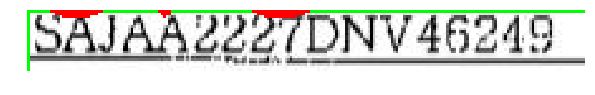

389 443 345 94 8 (1675, 1200, 3) 0.056119402985074625 0.006666666666666667 11.75
394 591 316 225 32 (1675, 1200, 3) 0.13432835820895522 0.02666666666666667 7.03125
399 470 298 106 9 (1675, 1200, 3) 0.06328358208955225 0.0075 11.777777777777779
421 89 248 65 8 (1675, 1200, 3) 0.03880597014925373 0.006666666666666667 8.125
444 908 115 70 5 (1675, 1200, 3) 0.041791044776119404 0.004166666666666667 14.0
453 454 110 42 5 (1675, 1200, 3) 0.02507462686567164 0.004166666666666667 8.4
458 322 108 131 9 (1675, 1200, 3) 0.07820895522388059 0.0075 14.555555555555555
465 269 107 38 5 (1675, 1200, 3) 0.022686567164179106 0.004166666666666667 7.6
467 157 106 69 5 (1675, 1200, 3) 0.04119402985074627 0.004166666666666667 13.8
475 102 64 243 34 (1675, 1200, 3) 0.14507462686567163 0.028333333333333332 7.147058823529412
485 810 40 89 8 (1675, 1200, 3) 0.05313432835820896 0.006666666666666667 11.125
489 379 37 695 96 (1675, 1200, 3) 0.41492537313432837 0.08 7.239583333333333
493 620 84 38 3 (1675, 1200, 3)

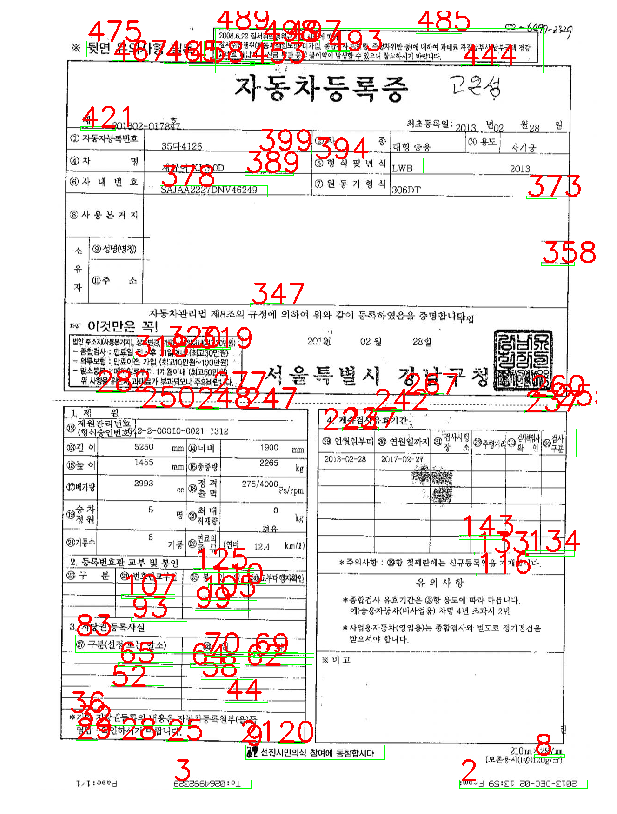

In [18]:
image, contours, hierachy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = imgwcon = raw.copy()

idx =0 
roi = []
selected_roi = []
for cnt in contours:
    idx += 1
    x, y, w, h = cv2.boundingRect(cnt)
    
    channel = img.shape
    
    if ((w/h > 7) & (w/h < 15)):
        roi = img[y: y + h, x: x + w]
        imgwcon = cv2.rectangle(imgwcon, (x, y), (x + w + 10, y + h), (0, 255, 0), 1)
        imgwcon = cv2.putText(imgwcon, str(idx), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 4)
        print (idx, x, y, w, h, channel, w/channel[0], h/channel[1], w/h)

        if (idx == FILE_INDEX):
            selected_roi = roi.copy()
            print ("!!!")
            plt.figure(figsize = (10, 5))
            plt.imshow(roi, cmap = "gray")
            plt.axis("off")
            plt.show()
            cv2.imwrite('Crop.png', roi)
                    
plt.figure(figsize = (10, 20))
plt.imshow(imgwcon, cmap = "gray")
plt.axis("off")
plt.show()

## 간단한 CNN으로 데이터 분석해보기

### MNIST 예제로 CNN 구현 및 확인하기

#### MNIST 예제 다운로드

In [19]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("./data/")

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [20]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

#### input 크기 설정

In [21]:
height = 28
width = 28
channels = 1
n_inputs = height * width

#### CNN의 parameters 설정

In [22]:
conv1_fmaps = 32
conv1_ksize = 5
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

#### CNN 구조 설계

#### input layer 설정

In [23]:
with tf.name_scope("inputs"):
    x = tf.placeholder(tf.float32, shape = [None, n_inputs], name = "x")
    x_reshaped = tf.reshape(x, shape = [-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape = [None], name = "y")

#### convolutional layer 설정

In [24]:
conv1 = tf.layers.conv2d(x_reshaped, filters = conv1_fmaps, kernel_size = conv1_ksize,
                         strides = conv1_stride, padding = conv1_pad,
                         activation = tf.nn.relu, name = "convolution1")
conv2 = tf.layers.conv2d(conv1, filters = conv2_fmaps, kernel_size = conv2_ksize,
                         strides = conv2_stride, padding = conv2_pad,
                         activation = tf.nn.relu, name = "convolution2")

#### pooling layer 설정

In [25]:
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "VALID")
    pool3_flat = tf.reshape(pool3, shape = [-1, pool3_fmaps * 7 * 7])

#### fully connected layer 설정

In [26]:
with tf.name_scope("fully_connected1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation = tf.nn.relu, name = "fully_connected1")

#### output layer 설정

In [27]:
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name = "output")
    y_predicted = tf.nn.softmax(logits, name = "y_predicted")

#### optimizaiton 설정

In [28]:
with tf.name_scope("optimization"):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = y)
    loss = tf.reduce_mean(cross_entropy) 
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

#### evaluation 설정

In [29]:
with tf.name_scope("evaluation"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [30]:
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

#### train

In [31]:
n_epochs = 5
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            x_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {x: x_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict = {x: x_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict = {x: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, ", Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_cnn_model.ckpt")

0 Train accuracy: 0.99 , Test accuracy: 0.9794
1 Train accuracy: 0.99 , Test accuracy: 0.9849
2 Train accuracy: 0.98 , Test accuracy: 0.9872
3 Train accuracy: 0.99 , Test accuracy: 0.9866
4 Train accuracy: 1.0 , Test accuracy: 0.9893


In [32]:
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_cnn_model.ckpt") # or better, use save_path
    x_new_scaled = mnist.test.images[:20]
    z = logits.eval(feed_dict = {x: x_new_scaled})
    y_pred = np.argmax(z, axis = 1)

INFO:tensorflow:Restoring parameters from ./my_mnist_cnn_model.ckpt


In [33]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])

Predicted classes: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [34]:
import matplotlib.cm

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

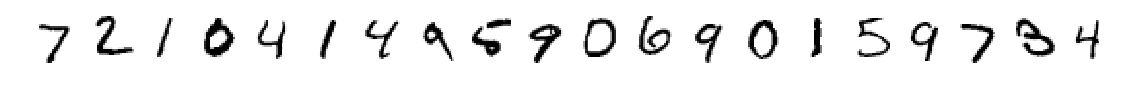

In [35]:
plt.figure(figsize = (20,1))
example_images = np.r_[x_new_scaled]
plot_digits(example_images, images_per_row = 20)
plt.show()

In [36]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:870px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [37]:
show_graph(tf.get_default_graph())

### Amazon 데이터 적용해보기

In [73]:
sys.path.append('./src') # 필요 코드 경로 설정
sys.path.append('./tests') # 필요 코드 경로 설정

In [39]:
# Data Preprocessing
import data_helper
from data_helper import AmazonPreprocessor
from kaggle_data.downloader import KaggleDataDownloader

Using TensorFlow backend.


In [40]:
# Deep Learning 관련
import tensorflow as tf # 행렬 연산에 특화된 모델 설계 관련 기능 지원
from keras.optimizers import Adam # tensorflow를 활용한 모델 설계 관련 기능 지원
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import vgg16
%matplotlib inline

In [41]:
train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = get_jpeg_data_files_paths()
labels_data_frame = pd.read_csv(train_csv_file, engine = 'c')
labels_data_frame.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

#### Labels 종류 확인하기

In [42]:
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_data_frame['tags'].values]))
labels_set = set(labels_list)
pd.DataFrame({"labels":list(labels_set)})

labels
0       partly_cloudy
1      artisinal_mine
2               water
3          habitation
4   conventional_mine
5         bare_ground
6               clear
7              cloudy
8   selective_logging
9           blow_down
10           blooming
11         slash_burn
12               haze
13            primary
14        cultivation
15               road
16        agriculture

#### Labels의 빈도수 확인

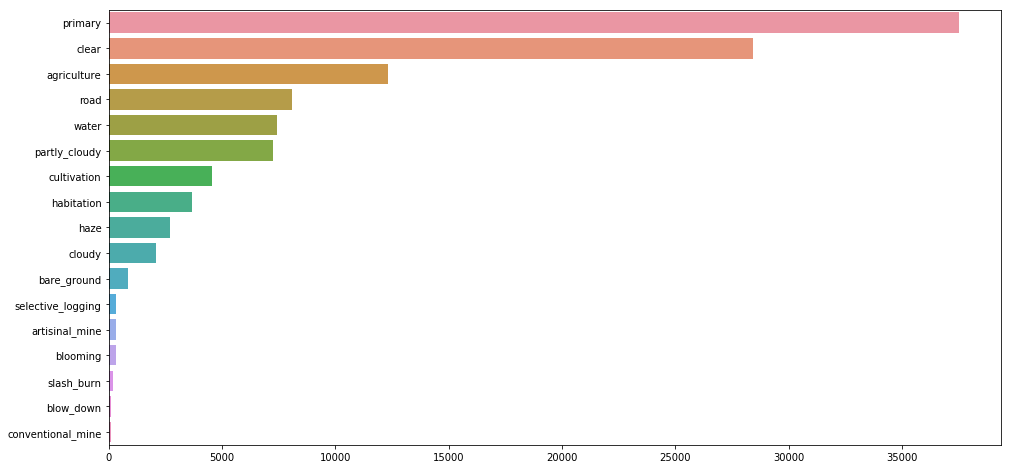

In [43]:
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(x = labels_s, y = labels_s.index, orient = 'h')

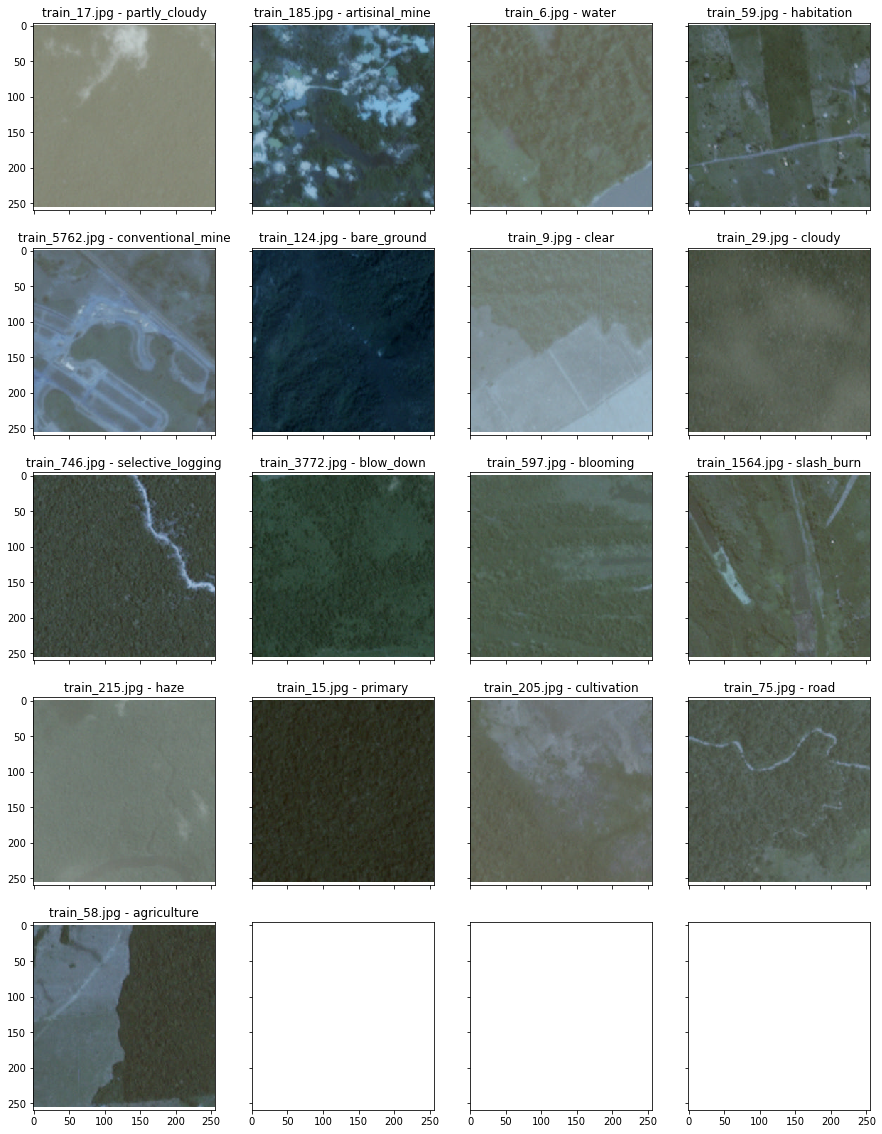

In [44]:
images_title = [labels_data_frame[labels_data_frame['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex = 'col', sharey = 'row', figsize = (15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = cv2.imread(train_jpeg_dir + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

#### 이미지 데이터 변형하기

In [45]:
def image_data_generator(image, rotation_range, shear_range, vertical_flip = True, horizontal_flip = True):
    result_image = image_normalized = cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    
    rotation_angle = np.random.uniform(rotation_range) - rotation_range/2
    height, width, ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((width/2, height/2), rotation_angle, 1)
    
    # Shear
    point1 = int(width * 0.01)
    point2 = int(height * 0.5) + point1
    point_set1 = np.float32([[point1, point1],[point2, point1],[point1, point2]])

    shear_point1 = point1 + shear_range * np.random.uniform() - shear_range / 2
    shear_point2 = point2 + shear_range * np.random.uniform() - shear_range / 2
    
    point_set2 = np.float32([[shear_point1, point1], [shear_point2, shear_point1], [point1, shear_point2]])
    shear_M = cv2.getAffineTransform(point_set1, point_set2)
    
    result_image = cv2.warpAffine(result_image, shear_M, (width, height))
    result_image = cv2.warpAffine(result_image, Rot_M, (width, height))
    
    vertical = randint(0, 1)
    horizontal = randint(0, 1)
    if vertical_flip and vertical:
        result_image = cv2.flip(result_image, 0)
    if horizontal_flip and horizontal:
        result_image = cv2.flip(result_image, 1)
    
    return result_image.copy()

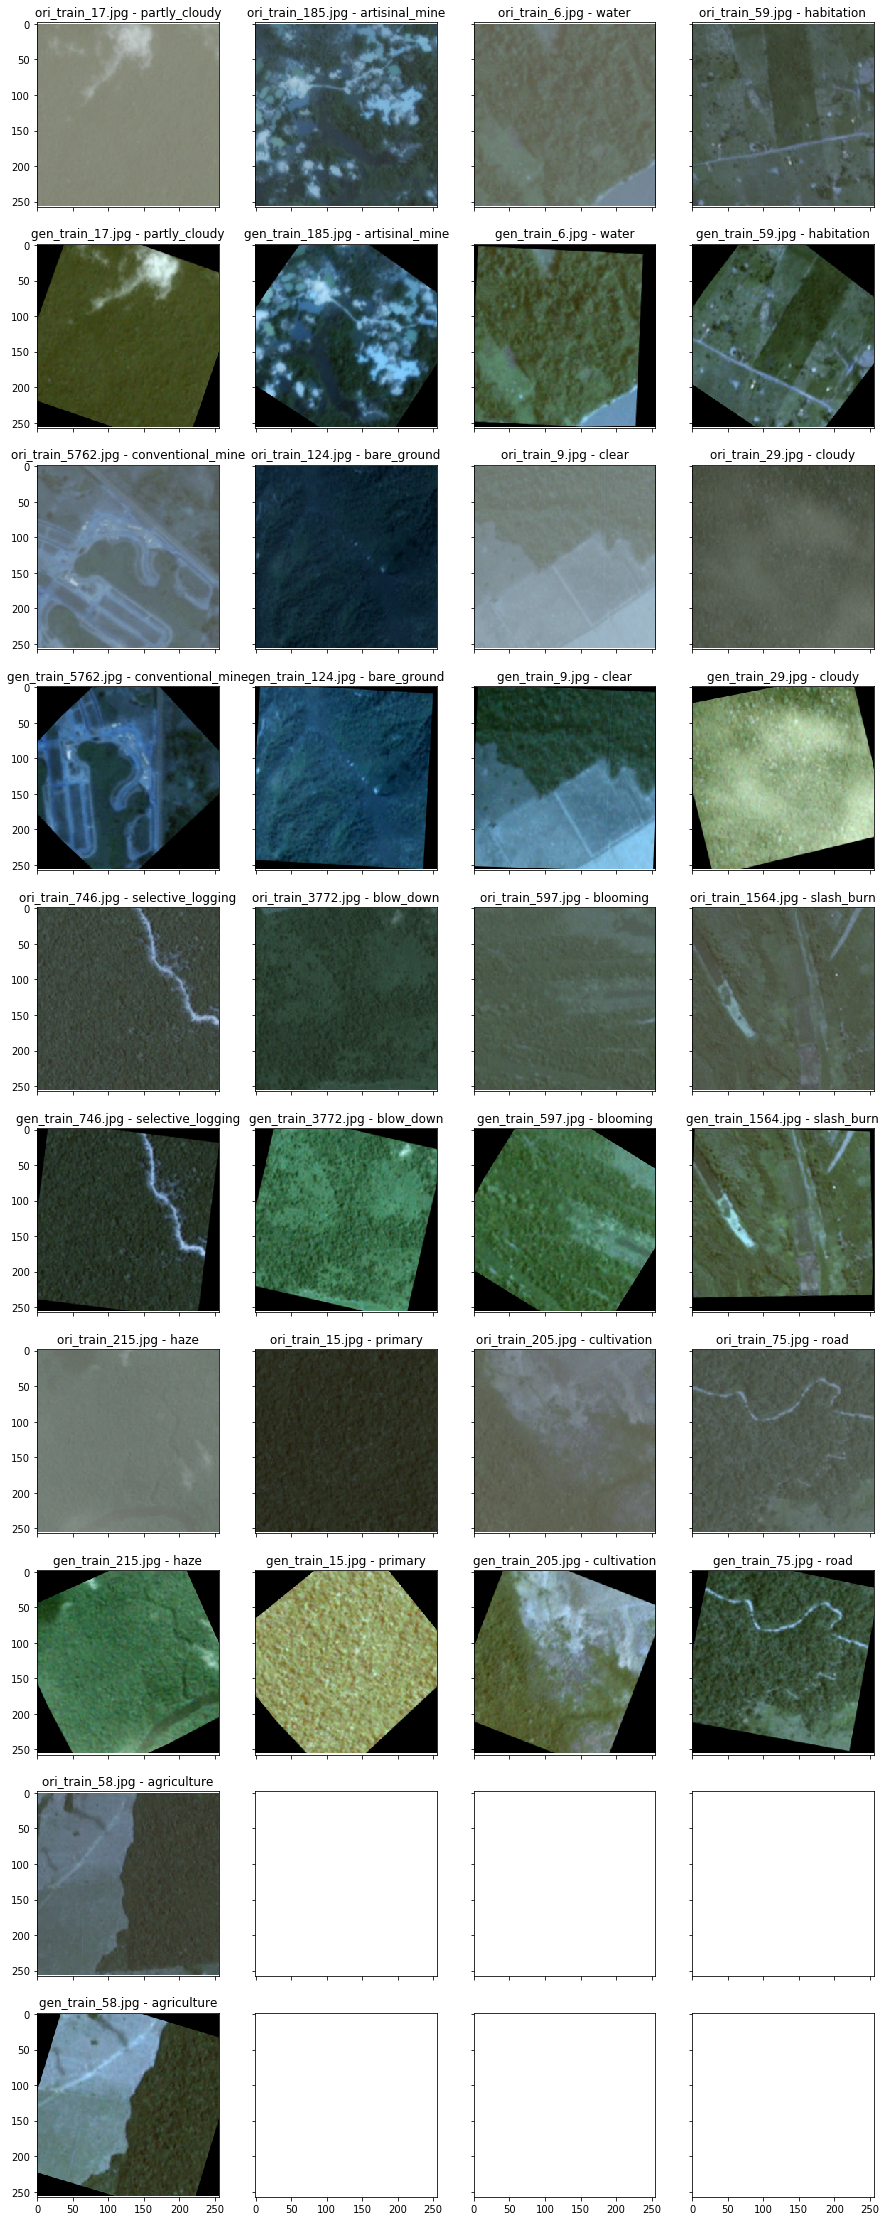

In [46]:
images_title = [labels_data_frame[labels_data_frame['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(10, 4, sharex = 'col', sharey = 'row', figsize = (15, 40))
axs = axs.ravel()

ori_counts = 0
gen_counts = 4
for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = cv2.imread(train_jpeg_dir + '/' + image_name)
    
    axs[ori_counts].imshow(img)
    axs[gen_counts].imshow(image_data_generator(img, 90, 20, False, False))
    axs[ori_counts].set_title('ori_{} - {}'.format(image_name, label))
    axs[gen_counts].set_title('gen_{} - {}'.format(image_name, label))
    
    if (i+1)%4 == 0:
        ori_counts = ori_counts + 5
        gen_counts = gen_counts + 5
    else:
        ori_counts = ori_counts + 1
        gen_counts = gen_counts + 1

In [47]:
def image_data_generator(image, rotation = True, vertical_flip = True, horizontal_flip = True):
    height, width = image.shape[:2]
    result_image = cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    if rotation:
        rotation_list = [0, 90, 180, 270]
        rotation_index = randint(0, 3)
        rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), rotation_list[rotation_index], 1)
        result_image = cv2.warpAffine(result_image, rotation_matrix, (width, height))
    
    vertical = randint(0, 1)
    horizontal = randint(0, 1)
    if vertical_flip and vertical:
        result_image = cv2.flip(result_image, 0)
    if horizontal_flip and horizontal:
        result_image = cv2.flip(result_image, 1)
    
    return result_image.copy()

#### Zero Mean Normalization

![zeromeannormalization](http://aikorea.org/cs231n/assets/nn2/prepro1.jpeg)

In [48]:
def preprcocessing_image_data(file_name):
    image = cv2.imread("{}/{}.jpg".format(train_jpeg_dir, file_name))
    image = cv2.resize(image, (48, 48))
    img_array = np.array(image, dtype = np.float32)
    img_array[:, :, 0] -= 104.939
    img_array[:, :, 1] -= 115.779
    img_array[:, :, 2] -= 124.68
    img_array = img_array / 255
    image_generated = image_data_generator(image)
    
    return image.copy(), image_generated.copy()

#### tags for mulit labels 생성

In [49]:
def get_class_mapping(*args):
    file_path, tags_str, labels_map = list(args[0])
    targets = np.zeros(len(labels_map))

    for t in tags_str.split(' '):
        targets[labels_map[t]] = 1

    return targets

In [50]:
img_resize = (48, 48)
validation_split_size = 0.2

In [51]:
preprocessor = AmazonPreprocessor(train_jpeg_dir, train_csv_file, test_jpeg_dir, test_jpeg_additional, 
                                  img_resize, validation_split_size)
preprocessor.init()

100%|██████████| 8096/8096 [00:00<00:00, 171683.39it/s]


Transforming val dataset...


100%|██████████| 8096/8096 [00:06<00:00, 1180.06it/s]


Done. Size consumed by validation matrices 213.46875 mb


In [52]:
print("X_train/y_train length: {}/{}".format(len(preprocessor.X_train), len(preprocessor.y_train)))
print("X_val/y_val length: {}/{}".format(len(preprocessor.X_val), len(preprocessor.y_val)))
print("X_test/X_test_filename length: {}/{}".format(len(preprocessor.X_test), len(preprocessor.X_test_filename)))
preprocessor.y_map

X_train/y_train length: 32383/32383
X_val/y_val length: 8096/8096
X_test/X_test_filename length: 61191/61191


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

In [53]:
model = vgg16.create_model(img_dim=(48, 48, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 3)         12        
_________________________________________________________________
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                8721      
Total params: 14,723,421
Trainable params: 14,723,415
Non-trainable params: 6
_________________________________________________________________


In [58]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='./weights/weights.best.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]

In [59]:
X_train, y_train = preprocessor.X_train, preprocessor.y_train
X_val, y_val = preprocessor.X_val, preprocessor.y_val

In [60]:
batch_size = 128
train_generator = preprocessor.get_train_generator(batch_size)
steps = len(X_train) / batch_size

In [62]:
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(train_generator, steps, epochs=25, verbose=1, 
                    validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/25
253/252 [==============================] - 62s 244ms/step - loss: 0.1059 - acc: 0.9587 - val_loss: 0.1029 - val_acc: 0.9598

Epoch 00001: val_loss improved from 0.10596 to 0.10293, saving model to ./weights/weights.best.hdf5
Epoch 2/25
253/252 [==============================] - 59s 233ms/step - loss: 0.1003 - acc: 0.9607 - val_loss: 0.1018 - val_acc: 0.9604

Epoch 00002: val_loss improved from 0.10293 to 0.10176, saving model to ./weights/weights.best.hdf5
Epoch 3/25
253/252 [==============================] - 59s 234ms/step - loss: 0.0967 - acc: 0.9621 - val_loss: 0.1006 - val_acc: 0.9608

Epoch 00003: val_loss improved from 0.10176 to 0.10063, saving model to ./weights/weights.best.hdf5
Epoch 4/25
253/252 [==============================] - 59s 232ms/step - loss: 0.0939 - acc: 0.9631 - val_loss: 0.1014 - val_acc: 0.9606

Epoch 00004: val_loss did not improve
Epoch 5/25
253/252 [==============================] - 59s 233ms/step - loss: 0.0917 - acc: 0.9639 - val_loss: 0.1004 -

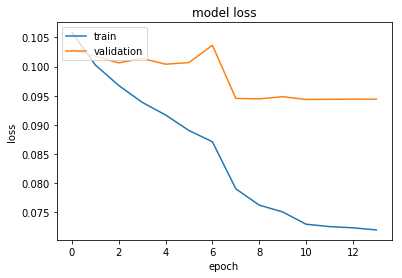

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [64]:
model.load_weights("weights/weights.best.hdf5")
print("Weights loaded")

Weights loaded


In [65]:
fbeta_score = vgg16.fbeta(model, X_val, y_val)

fbeta_score

0.9177606518289333

In [66]:
predictions, x_test_filename = vgg16.predict(model, preprocessor, batch_size=128)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              x_test_filename[0], predictions[0]))

479/478 [==============================] - 79s 165ms/step
Predictions shape: (61191, 17)
Files name shape: (61191,)
1st predictions (test_25762) entry:
[5.7499075e-01 3.8941868e-03 9.0279311e-02 1.8504180e-04 1.2764861e-04
 4.8025686e-01 1.2148393e-03 2.1538027e-03 6.5538853e-02 5.9172254e-02
 1.2192175e-02 4.5940834e-01 9.7548091e-01 1.3765192e-01 7.9156552e-04
 6.6802488e-04 9.7619802e-01]


In [68]:
thresholds = [0.2] * len(labels_set)

predicted_labels = vgg16.map_predictions(preprocessor, predictions, thresholds)

tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [69]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
print("Predictions rows:", final_df.size)
final_df.head()

Predictions rows: 122382


image_name                                             tags
0  test_25762    agriculture clear partly_cloudy primary water
1  test_28570                   agriculture clear haze primary
2  test_29242                                    clear primary
3  test_29263  agriculture blow_down clear cultivation primary
4  test_10190                            partly_cloudy primary

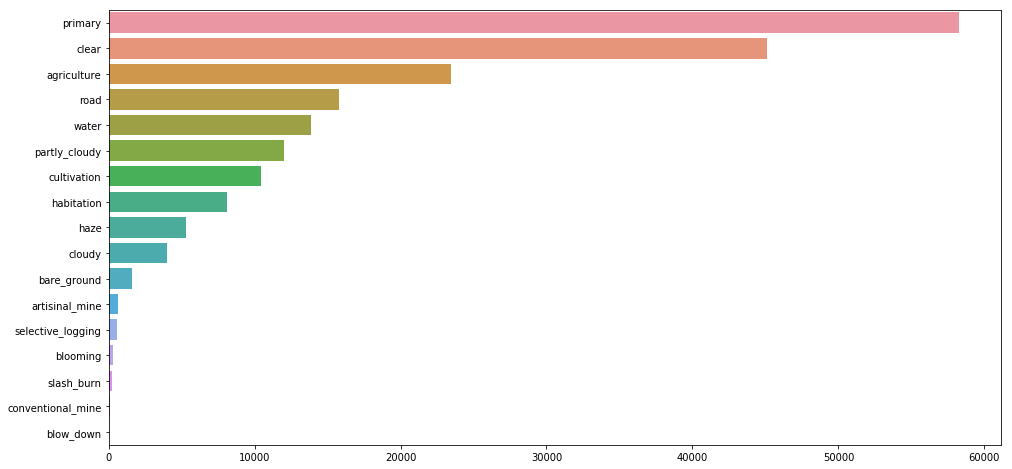

In [70]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

In [72]:
final_df.to_csv('./submission_file.csv', index = False)